# trace demo

## overview

this is a quick guide demonstrating simple analysis of data generated by the TRACE system. we will analyze the 4 day recording (Fig. 2-3 in the Science manuscript).

## load libraries
load the utility functions as well as a few python libraries for analysis, visualization, etc.

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # most plotting is done using matplotlib.pyplot
import seaborn as sns           # and seaborn
sns.set_style("white")

# jupyter magic to generate plots inline
%matplotlib inline

from IPython.display import display # for displaying pandas DataFrames

# import the utility functions
%run ../util/array_analysis_funcs.py

## set data directory, constants
set the directory from which the input files will be drawn from. we are using a set of samples corresponding to all 16 possible 4 day input profiles. these samples have been sequenced with a size-enrichment method. 

In [2]:
# input data directory
data_dir = '../data/4day_en/' 
# these are our preferred chars for representing [R]eference vs p[T]rig spacers
char_pair = ('R','T') 
# generate all 16 day D4 input profiles
# X denotes "OFF" while O denotes "ON"
# i.e., XXXX, XXXO, XXOX, ... , OOOO
D4_sample_list = make_sample_list(4)                 

## count raw array types
for each sample (i.e., file in the input data directory), we count up the numbers of each type of array for all specified array lengths (i.e., array lengths 1-5). the resulting object is a dictionary of dictionaries:
```
count_dict['sample_name'][array_length] = < pandas Series object of counts indexed by array type >
```

In [3]:
# read files (*_uniq.txt), count up the raw arrays of each type for each sample
# NB: since the raw files, which contain spacer sequences, are >50MB, 
# we provide a pickle of the output of this command for demo purposes
# raw_counts_dict = array_counts_from_spacers(data_dir,
#                                             samples=D4_sample_list,
#                                             char_pair=char_pair,
#                                             do_dedup=False)
# 
# pickle.dump(raw_counts_dict, open(data_dir+'raw_counts.pkl','wb'))
raw_counts_dict = pickle.load(open(data_dir+'raw_counts.pkl', "rb"))

In [4]:
# take a quick look at some of the raw array counts
print 'OOXX array length 3 counts' 
print raw_counts_dict['OOXX'][3]
print ''
print 'XXOO array length 3 counts' 
print raw_counts_dict['XXOO'][3]

OOXX array length 3 counts
RRR    4318
RRT    1353
RTR     606
RTT     174
TRR     168
TRT      41
TTR      18
TTT       7
dtype: int64

XXOO array length 3 counts
RRR    3153
RRT     136
RTR     344
RTT      14
TRR     928
TRT      29
TTR     136
TTT      11
dtype: int64


## plot %pTrig spacer heatmaps
for each sample, we plot the proportion of pTrig spacers detected for array lengths L1 to L5 at different positions (p1 to p5). p1 corresponds to the most recently incorportated spacer, p2 corresponds to the second most recently incorporated spacer, etc.

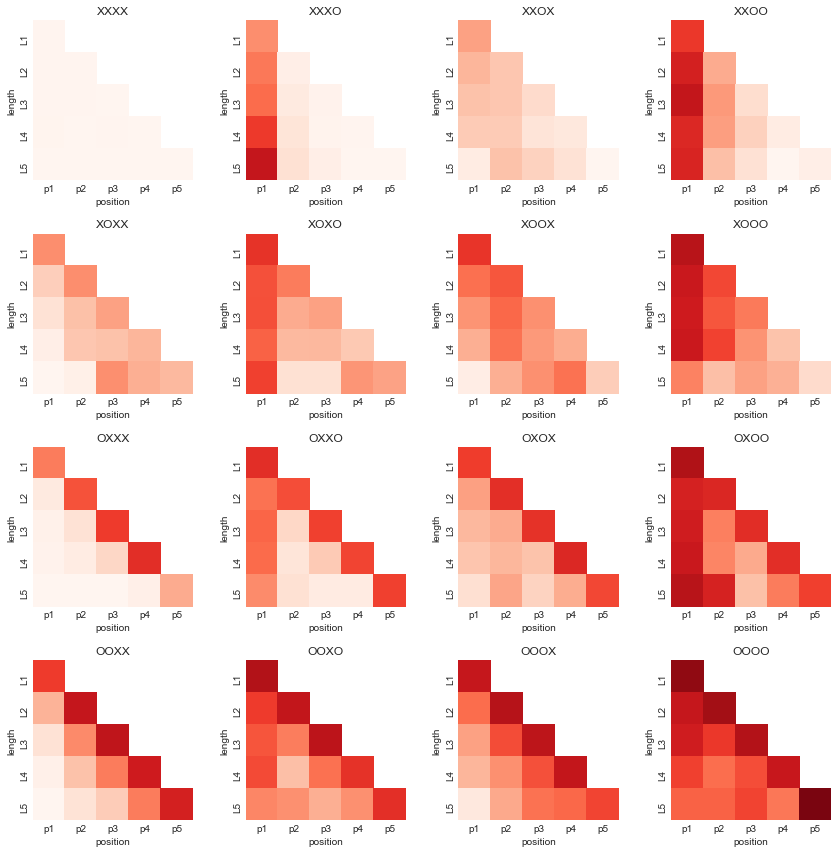

In [5]:
plot_spacer_heatmaps(raw_counts_dict, samples=D4_sample_list, method='from_raw_vector', 
                     char_pair=char_pair, subplot_width=4)

## generate modeled array type probabilities
for each sample, we can model probabilities of seeing each array type for lengths L1-L4 based on a few parameters, namely probabilities of array expansion and pTrig spacer incorporation on ON (O) or OFF (X) days. the parameters utilized in the paper are used as default in the utility functions, but other values can be passed to the calc_mult_sample_array_probs function. since the model assumes a maximum of 1 spacer incorporation per day, we ignore L5 array type probabilities.

In [6]:
# generate modeled array type probabilities, use default values
modeled_probs_dict = calc_mult_sample_array_probs(D4_sample_list, arr_lens=[1,2,3,4], 
                                                  char_pair=char_pair)

In [7]:
# take a quick look at some of the modeled array probabilities
print 'OOXX array length 3 modeled probabilities'
print modeled_probs_dict['OOXX'][3]
print ''
print 'XXOO array length 3 modeled probabilities'
print modeled_probs_dict['XXOO'][3]

OOXX array length 3 modeled probabilities
RRR    5.830441e-04
RRT    1.646401e-04
RTR    1.151363e-04
RTT    3.251219e-05
TRR    4.084168e-07
TRT    1.153288e-07
TTR    8.065184e-08
TTT    2.277447e-08
dtype: float64

XXOO array length 3 modeled probabilities
RRR    5.830441e-04
RRT    4.084168e-07
RTR    1.151363e-04
RTT    8.065184e-08
TRR    1.646401e-04
TRT    1.153288e-07
TTR    3.251219e-05
TTT    2.277447e-08
dtype: float64


## plot data vs. modeled array type distributions
we can plot the normalized distributions of each length L4 array type for both data and model. one can make similar plots for lengths L1-L3 if desired.

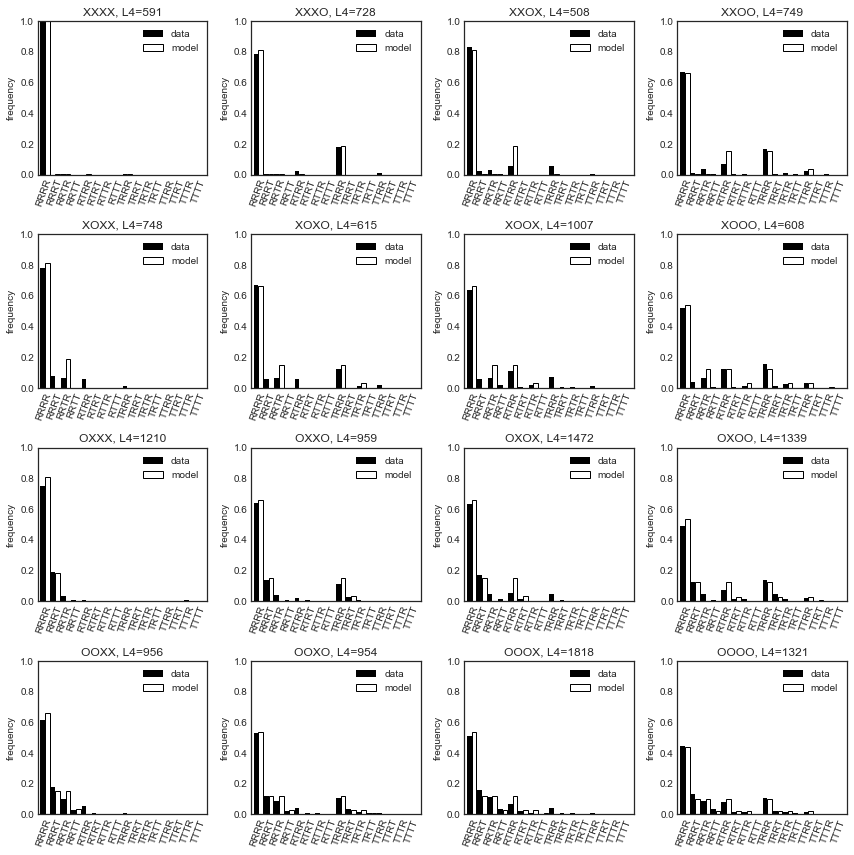

In [8]:
# plot data vs. modeled array type distributions
plot_array_vectors(raw_counts_dict, modeled_probs_dict, array_len=4, samples=D4_sample_list,
                   subplot_width=4, figsize=(12,12))

## obtain normalized array type vectors from data, model
at the moment, for each sample we only have raw counts of array types (data) and probabilities of array types (model). if we want to compare them, they will have to be normalized into array type vectors for a given array length. in this case, we will obtain the normalized array type vectors for array lengths L2-L4 and take the additional step of concatenating them into a single vector for each sample.

In [9]:
# obtain normalized array type vectors from raw data counts for lengths L2-L4
dat_array_vectors_concat = pd.DataFrame(index=D4_sample_list)
for i in [2,3,4]: # for each array length...
    tmp_df = extract_array_vectors(raw_counts_dict, samples=D4_sample_list, 
                                   array_len=i, out_type='pd_df')
    dat_array_vectors_concat = dat_array_vectors_concat.join( tmp_df )
    
# let's take a look at the normalized vectors for the first 3 samples
display(dat_array_vectors_concat.iloc[0:3,:])

,RR,RT,TR,TT,RRR,RRT,RTR,RTT,TRR,TRT,...,RTTR,RTTT,TRRR,TRRT,TRTR,TRTT,TTRR,TTRT,TTTR,TTTT
XXXX,0.997422,0.001250,0.001328,0.000000,0.995751,0.000797,0.002124,0.000000,0.001328,0.000000,...,0.0,0.0,0.003384,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
XXXO,0.854573,0.009115,0.133133,0.003178,0.831122,0.003639,0.016267,0.000642,0.143836,0.000428,...,0.0,0.0,0.181319,0.0,0.0,0.0,0.008242,0.0,0.0,0.0
XXOX,0.858546,0.061282,0.078163,0.002008,0.828526,0.040378,0.060304,0.002098,0.067121,0.000262,...,0.0,0.0,0.055118,0.0,0.0,0.0,0.003937,0.0,0.0,0.0


In [10]:
# obtain normalized array type vectors from model probabilities for lengths L2-L4
mod_array_vectors_concat = pd.DataFrame(index=D4_sample_list)
for i in [2,3,4]:
    tmp_df = extract_array_vectors(modeled_probs_dict, samples=D4_sample_list, 
                                   array_len=i, out_type='pd_df')
    mod_array_vectors_concat = mod_array_vectors_concat.join( tmp_df )

# let's take a look at the normalized vectors for the first 3 samples    
display(mod_array_vectors_concat.iloc[0:3,:])

,RR,RT,TR,TT,RRR,RRT,RTR,RTT,TRR,TRT,...,RTTR,RTTT,TRRR,TRRT,TRTR,TRTT,TTRR,TTRT,TTTR,TTTT
XXXX,0.998600,0.000700,0.000700,4.900000e-07,0.997901,0.000699,0.000699,4.896570e-07,0.000699,4.896570e-07,...,4.893142e-07,3.427599e-10,0.000699,4.893142e-07,4.893142e-07,3.427599e-10,4.893142e-07,3.427599e-10,3.427599e-10,2.401000e-13
XXXO,0.815443,0.000571,0.183857,1.287900e-04,0.800828,0.000561,0.000561,3.929555e-07,0.197773,1.385380e-04,...,3.983360e-07,2.790305e-10,0.186109,1.303673e-04,1.303673e-04,9.132103e-08,1.303673e-04,9.132103e-08,9.132103e-08,6.396950e-11
XXOX,0.815443,0.061666,0.122762,1.287900e-04,0.800828,0.000561,0.132036,9.248964e-05,0.066298,4.644130e-05,...,1.303673e-04,9.132103e-08,0.000569,3.983360e-07,3.983360e-07,2.790305e-10,1.303673e-04,9.132103e-08,9.132103e-08,6.396950e-11


## calculate Euclidean distance between data and model vectors
to perform reconstruction of temporal profiles, we can compare the Euclidean distance between the data and model vectors obtained above. the modeled sample profile with minimum distance to a given data sample is our "predicted" profile so we plot heatmaps for both.

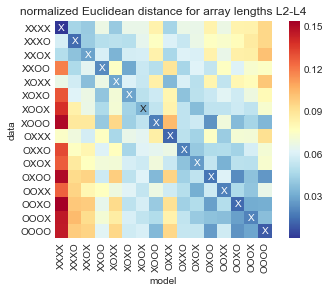

In [11]:
# calculate Euclidean distance b/w data and model vectors; plot as heatmap
dist_mat_concat = calc_euc_distance_matrix(freq_data=dat_array_vectors_concat,
                                           freq_mod =mod_array_vectors_concat)
dist_mat_concat_row_norm = dist_mat_concat.div(dist_mat_concat.sum(axis=1), axis=0)
plot_heatmap(dist_mat_concat_row_norm, row_nms=dist_mat_concat.index.values,
             col_nms=dist_mat_concat.columns.values, mark_matches=True, # mark "correct" pred. 
             title_text='normalized Euclidean distance for array lengths L2-L4', 
             cmap='RdYlBu_r')

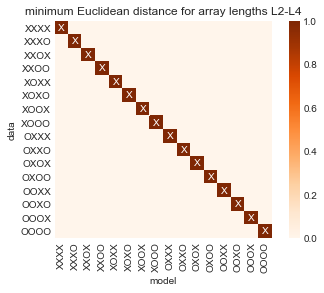

In [12]:
# find minimum Euclidean distance b/w data and model vectors; plot as indicator "heatmap"
min_mat_concat = calc_min_indicator_matrix(dist_mat_concat)
plot_heatmap(min_mat_concat, row_nms=dist_mat_concat.index.values,
             col_nms=dist_mat_concat.columns.values, mark_matches=True, # mark "correct" pred.
             title_text='minimum Euclidean distance for array lengths L2-L4')